# Simulated NISAR Access and Exploration

Authors: Rajat Shinde (UAH), Sheyenne Kirkland (UAH), Julia Signell, Alex Mandel (DevSeed)

Date: June 24, 2024

Description: In this tutorial, we'll demonstrate how to access simulated NISAR data from the [MAAP STAC Catalog](https://stac-browser.maap-project.org/?.language=en). We'll use two methods to retrieve temporary S3 credentials, and xarray's `DataTree` to explore the data and create a visualization.

## Run This Notebook

To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the ["Getting started with the MAAP"](https://docs.maap-project.org/en/latest/getting_started/getting_started.html) section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors. Additionally, it is recommended to use the `Pangeo` workspace within the ADE, since certain packages relevant to this tutorial are already installed.

## About the Data

There are a set of sample products using JAXA ALOS-1 PALSAR data as a surrogate for NISAR. The sample covers the full suite of planned products, from Level 0 raw data (in NISAR format) to Level 1 and Level 2. These data cover a smaller area than a NISAR frame, but the metadata content is fully compatible with the data NISAR will produce after entering the science phase. (Source: [Data Overview](https://nisar.jpl.nasa.gov/data/overview/))

NISAR is planned to launch later this year.

## Additional Resources
- [NISAR](https://nisar.jpl.nasa.gov/)
- [xarray Datatree](https://xarray-datatree.readthedocs.io/en/latest/)

## Import and Install Packages

The following are optional installs, as they should be included within the Pangeo workspace.

In [1]:
#!pip install -q xarray xarray-datatree

Run the following cell to import the packages necessary for this tutorial.

In [2]:
!pip install -q earthaccess

from maap.maap import MAAP
from pystac_client import Client
import xarray as xr
from datatree import open_datatree
import os
import s3fs
import earthaccess

maap = MAAP()

## Access the Data

Simulated NISAR data can be accessed through the MAAP STAC Catalog. To do this, we'll open the MAAP STAC catalog, and then use the collection ID "nisar-sim" to get our desired collection.

In [3]:
catalog = 'https://stac.maap-project.org/'
client = Client.open(catalog)

collection = client.get_collection('nisar-sim')
collection

<CollectionClient id=nisar-sim>

Let's pull the GCOV (Geocoded Polarimetric Covariance) product from the collection to work with. For more information on the L2 GCOV product, you can read more [here](https://nisar.asf.earthdatacloud.nasa.gov/NISAR-SAMPLE-DATA/DOCS/NISAR_D-102274_L2_GCOV_Product_Spec_R3.4_231109_clean_w-sigs.pdf). 

In [4]:
nisar_item = list(client.search(collections="nisar-sim").items())[7]
nisar_item

<Item id=NISAR_L2_PR_GCOV_001_005_A_219_4020_SHNA_A_20081012T060910_20081012T060926_P01101_F_N_J_001>

We can now get the S3 link, which is under "assets" > "GCOV" > "alternate".

In [5]:
s3_link = "s3://sds-n-cumulus-prod-nisar-sample-data/GCOV/ALOS1_Rosamond_20081012/NISAR_L2_PR_GCOV_001_005_A_219_4020_SHNA_A_20081012T060910_20081012T060926_P01101_F_N_J_001.h5"

Let's look at two methods that fetch temporary S3 credentials for the data from ASF (Alaska Satellite Facility).

### `maap-py`

The first method is using `maap-py`. We'll get the temporary credentials and pass them into `s3fs`.

In [18]:
def get_s3_creds(url):
    return maap.aws.earthdata_s3_credentials(url)

def get_s3_client(s3_cred_endpoint):
    creds=get_s3_creds(s3_cred_endpoint)
    boto3_session = boto3.Session(
            aws_access_key_id=creds['accessKeyId'],
            aws_secret_access_key=creds['secretAccessKey'],
            aws_session_token=creds['sessionToken']
    )
    return boto3_session.client("s3")

asf_s3 = "https://nisar.asf.earthdatacloud.nasa.gov/s3credentials"
creds = get_s3_creds(asf_s3)

# pass credentials into s3fs
fs_s3 = s3fs.S3FileSystem(anon=False, 
                          key=creds['accessKeyId'], 
                          secret=creds['secretAccessKey'], 
                          token=creds['sessionToken'])

### `earthaccess`

The second method is through `earthaccess`. For authentication, you'll need an Earthdata login or EDL. The cell below will allow you to manually enter your username and password (keyed out) if it cannot authenticate through a .netrc file or environment variables.

If you would like to learn how to persist your login information into a .netrc file, click [here](https://nasa-openscapes.github.io/earthdata-cloud-cookbook/tutorials/earthaccess-demo.html#auth).

In [ ]:
earthaccess.login()

Now that we're logged in, we can get our temporary credentials.

In [21]:
creds = earthaccess.__store__.auth.get_s3_credentials(endpoint=asf_s3)

Finally, we can pass those credentials into `s3fs`, similar to above with `maap-py`.

In [22]:
fs_s3 = s3fs.S3FileSystem(anon=False, 
                          key=creds['accessKeyId'], 
                          secret=creds['secretAccessKey'], 
                          token=creds['sessionToken'])

## Explore the Data

Since we retrieved our credentials and passed them into `s3fs`, we can now open our S3 url, which we pulled when opening our item.

In [23]:
nisar_file_obj = fs_s3.open(s3_link, mode='rb')

To further explore the data and prepare for visualization we'll use xarray's `DataTree`. This package will show our data in a nice hierarchical structure that we can navigate.

In [24]:
dt = open_datatree(nisar_file_obj, engine='h5netcdf', phony_dims='sort')
dt

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       Conventions:  CF-1.8
└── DataTree('science')
    └── DataTree('LSAR')
        ├── DataTree('GCOV')
        │   ├── DataTree('grids')
        │   │   └── DataTree('frequencyA')
        │   │           Dimensions:                                   (yCoordinates: 6220,
        │   │                                                          xCoordinates: 4545,
        │   │                                                          phony_dim_2: 1)
        │   │           Coordinates:
        │   │             * xCoordinates                              (xCoordinates) float64 3.655e+0...
        │   │             * yCoordinates                              (yCoordinates) float64 3.914e+0...
        │   │           Dimensions without coordinates: phony_dim_2
        │   │           Data variables: (12/15)
        │   │               HHHH                                      (yCoordinates, xCoordinates) float32 ...
        │   │               azimuthBandwidth                          float64 ...
        │   │               centerFrequency                           float64 ...
        │   │               listOfCovarianceTerms                     (phony_dim_2) |S4 ...
        │   │               listOfPolarizations                       (phony_dim_2) |S2 ...
        │   │               numberOfLooks                             (yCoordinates, xCoordinates) float32 ...
        │   │               ...                                        ...
        │   │               rangeBandwidth                            float64 ...
        │   │               rtcAreaNormalizationFactorGamma0ToSigma0  (yCoordinates, xCoordinates) float32 ...
        │   │               slantRangeSpacing                         float64 ...
        │   │               xCoordinateSpacing                        float64 ...
        │   │               yCoordinateSpacing                        float64 ...
        │   │               zeroDopplerTimeSpacing                    timedelta64[ns] ...
        │   └── DataTree('metadata')
        │       ├── DataTree('attitude')
        │       │       Dimensions:          (phony_dim_3: 22, phony_dim_4: 3, phony_dim_5: 4)
        │       │       Dimensions without coordinates: phony_dim_3, phony_dim_4, phony_dim_5
        │       │       Data variables:
        │       │           angularVelocity  (phony_dim_3, phony_dim_4) float64 ...
        │       │           attitudeType     |S10 ...
        │       │           eulerAngles      (phony_dim_3, phony_dim_4) float64 ...
        │       │           quaternions      (phony_dim_3, phony_dim_5) float64 ...
        │       │           time             (phony_dim_3) datetime64[ns] ...
        │       ├── DataTree('calibrationInformation')
        │       │   └── DataTree('frequencyA')
        │       │       └── DataTree('HH')
        │       │               Dimensions:                  (phony_dim_6: 611, phony_dim_7: 130)
        │       │               Dimensions without coordinates: phony_dim_6, phony_dim_7
        │       │               Data variables:
        │       │                   elevationAntennaPattern  (phony_dim_6, phony_dim_7) float32 ...
        │       │                   nes0                     (phony_dim_6, phony_dim_7) float32 ...
        │       │                   rfiLikelihood            float64 ...
        │       ├── DataTree('orbit')
        │       │       Dimensions:       (phony_dim_8: 28, phony_dim_9: 3)
        │       │       Dimensions without coordinates: phony_dim_8, phony_dim_9
        │       │       Data variables:
        │       │           acceleration  (phony_dim_8, phony_dim_9) float64 ...
        │       │           interpMethod  |S50 ...
        │       │           orbitType     |S10 ...
        │       │           position      (phony_dim_8, phony_dim_9) float64 ...
        │       │           time          (phony_dim_8) datetime6

## Visualize the Data

Finally, let's visualize our data using `matplotlib` via .plot(). Given what we discovered by inspecting the DataTree above, we know that we are interested in the "frequencyA" group. When we open the dataset, we can specify exactly that group.

We can use a simple plot function on the ds variable, and specify that we want to plot "numberOfLooks" under the "frequencyA" group. 

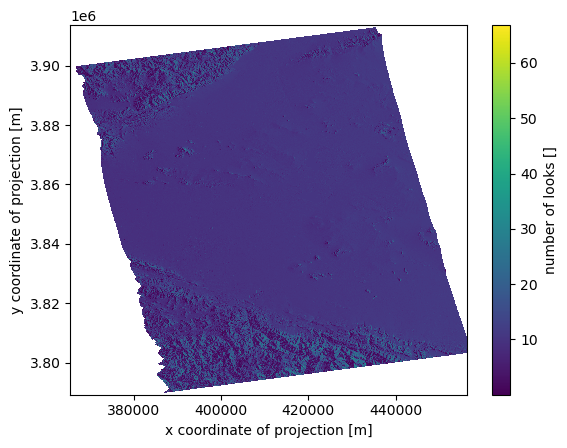

In [25]:
ds = dt["science/LSAR/GCOV/grids/frequencyA"].ds

ds.numberOfLooks.plot()